# Imports

In [1]:
import torch 

from transformers import ViTMAEForPreTraining, AutoImageProcessor

from src.vitmae.dataset import init_datasets, init_dataloaders
from src.vitmae.training import train

# Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image Processor

In [3]:
image_processor_checkpoint = r"facebook/vit-mae-base"
image_processor = AutoImageProcessor.from_pretrained(image_processor_checkpoint)

# Dataset

In [4]:
train_images_dir = r"C:\Internship\ITMO_ML\data\ViTMAE\train"
val_images_dir = r"C:\Internship\ITMO_ML\data\ViTMAE\val"

In [6]:
batch_size_train = 64
batch_size_val = 32
pin_memory = True
num_workers = 4

In [ ]:
train_dataset, val_dataset = init_datasets(
    train_images_dir=train_images_dir,
    val_images_dir=val_images_dir,
    image_processor=image_processor
)

In [ ]:
train_dataloader, val_dataloader = init_dataloaders(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size_train=batch_size_train,
    batch_size_val=batch_size_val,
    pin_memory=pin_memory,
    num_workers=num_workers
)

# Model

In [9]:
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
model = model.to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters())

In [11]:
save_dir = r"C:\Internship\ITMO_ML\CTCI\checkpoints\vit\vitmae_on_bubbles\run1"

In [13]:
history = train(
    model=model,
    optimizer=optimizer,
    train_dataloder=train_dataloader,
    val_dataloader=val_dataloader,
    device=device,
    save_dir=save_dir,
    num_epochs=20
)

Epoch 1:


100%|██████████| 292/292 [03:00<00:00,  1.62it/s]


Epoch train loss: 0.15656699115180805


100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch val loss: 0.11807890247840147
Epoch 2:


100%|██████████| 292/292 [03:00<00:00,  1.62it/s]


Epoch train loss: 0.11632616585758451


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch val loss: 0.11396016415495139
Epoch 3:


100%|██████████| 292/292 [02:58<00:00,  1.64it/s]


Epoch train loss: 0.11387903197375063


100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch val loss: 0.11222283112315032
Epoch 4:


100%|██████████| 292/292 [02:57<00:00,  1.64it/s]


Epoch train loss: 0.112599158608546


100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


Epoch val loss: 0.11171987326099322
Epoch 5:


100%|██████████| 292/292 [02:57<00:00,  1.64it/s]


Epoch train loss: 0.11157106268793753


100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch val loss: 0.11123914472185649
Epoch 6:


100%|██████████| 292/292 [02:58<00:00,  1.64it/s]


Epoch train loss: 0.11121711931000017


100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


Epoch val loss: 0.11014496701268049
Epoch 7:


100%|██████████| 292/292 [02:57<00:00,  1.64it/s]


Epoch train loss: 0.11026471360803466


100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch val loss: 0.10973055792542605
Epoch 8:


100%|██████████| 292/292 [02:58<00:00,  1.64it/s]


Epoch train loss: 0.10987156440746294


100%|██████████| 65/65 [00:12<00:00,  5.00it/s]


Epoch val loss: 0.10950277166870924
Epoch 9:


100%|██████████| 292/292 [02:58<00:00,  1.64it/s]


Epoch train loss: 0.10974061198226392


100%|██████████| 65/65 [00:13<00:00,  5.00it/s]

Epoch val loss: 0.1089396320283413


Epoch 10:


100%|██████████| 292/292 [02:55<00:00,  1.66it/s]


Epoch train loss: 0.10906846772828331


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch val loss: 0.10882378249214246
Epoch 11:


100%|██████████| 292/292 [02:55<00:00,  1.67it/s]


Epoch train loss: 0.10882374838198701


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch val loss: 0.10828170134471013
Epoch 12:


100%|██████████| 292/292 [02:55<00:00,  1.67it/s]


Epoch train loss: 0.10822091754270743


100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch val loss: 0.10812337920069695
Epoch 13:


100%|██████████| 292/292 [02:56<00:00,  1.65it/s]


Epoch train loss: 0.10792174353583218


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch val loss: 0.10823141691776422
Epoch 14:


100%|██████████| 292/292 [02:59<00:00,  1.63it/s]


Epoch train loss: 0.10768453059845591


100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


Epoch val loss: 0.10755381996815021
Epoch 15:


100%|██████████| 292/292 [02:59<00:00,  1.63it/s]


Epoch train loss: 0.10722834019832415


100%|██████████| 65/65 [00:15<00:00,  4.32it/s]


Epoch val loss: 0.1076127736041179
Epoch 16:


100%|██████████| 292/292 [03:01<00:00,  1.61it/s]


Epoch train loss: 0.1067309365288852


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epoch val loss: 0.1068803109228611
Epoch 17:


100%|██████████| 292/292 [02:59<00:00,  1.63it/s]


Epoch train loss: 0.10632286914815642


100%|██████████| 65/65 [00:13<00:00,  4.91it/s]


Epoch val loss: 0.10670854546702825
Epoch 18:


100%|██████████| 292/292 [02:59<00:00,  1.63it/s]


Epoch train loss: 0.10597253368835743


100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch val loss: 0.10659880294249607
Epoch 19:


100%|██████████| 292/292 [02:58<00:00,  1.63it/s]


Epoch train loss: 0.1054028498187457


100%|██████████| 65/65 [00:13<00:00,  4.89it/s]


Epoch val loss: 0.10624640349012154
Epoch 20:


100%|██████████| 292/292 [02:58<00:00,  1.63it/s]


Epoch train loss: 0.10489125539586969


100%|██████████| 65/65 [00:13<00:00,  4.88it/s]


Epoch val loss: 0.10556046148905388


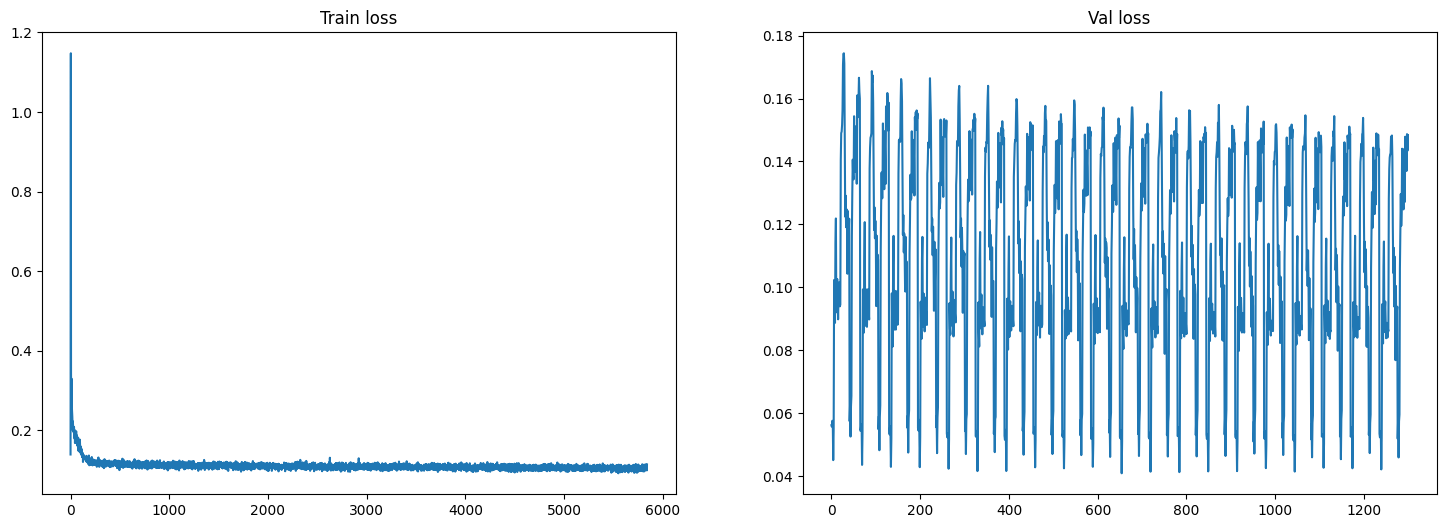

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 6)

ax[0].plot(range(len(history["train"])), history["train"])
ax[0].set_title("Train loss")
ax[1].plot(range(len(history["val"])), history["val"])
ax[1].set_title("Val loss")

plt.show()